# Исследование рынка компьютерных игр

Для анализа предоставлен набор исторических данных о продажах игр, включая оценки пользователей и экспертов, жанры и платформы. 

Задача: на основе имеющихся данных выявить критерии и характеристики, которые определяют популярность игры, чтобы на основании этой информации прогнозировать успешность продукта.


## Изучение данных 

Импортируем необходимые для проекта библиотеки:

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
from scipy import stats as st
from pymystem3 import Mystem

Прочитаем таблицу, содержащую исходные данные, и сохраним в переменной **df**. Чтобы провести предварительную оценку данных, посмотрим первые строки и общую информацию.

In [2]:
df = pd.read_csv('/datasets/games.csv')
pd.set_option("display.max_columns", None) #для отображения всех столбцов

display(df.head(10))
df.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Таблица состоит из 11 столбцов разного типа:
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board)

В нескольких столбцах присутствуют пропуски. В заголовках присутствует разный регистр, желательно это исправить.

Посмотрим некоторые характеристики датасета, используя метод `describe`.

In [3]:
df.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


В таблице предоставлены данные за 1980-2016 годы. Основные продажи в Северной Америке и Европе. На Японию и другие регионы приходится не очень большая часть.

## Предобработка данных

Столбцы названы с использованием разного регистра. Скорректируем, чтобы все названия были в нижнем регистре.

In [4]:
df.columns = df.columns.str.lower()

Заполним пропуски и изменим тип данных в некоторых столбцах.

В столбце с названием есть два пропуска. Посмотрим, есть ли информация в других столбцах по этим позициям, которая может оказаться нам полезной.

In [5]:
df.query('name != name')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Пропуски присутствуют и в некоторых других столбцах, удалим эти позиции.

In [6]:
df.dropna(subset = ['name'], inplace = True)


В столбце с годом выпуска присутствуют пропуски по 269 позициям. Но в названии некоторых игр присутствует год. Попробуем использовать год из названия, чтобы заполнить часть пропусков. 

Бывает, что релиз игры происходит в конце года и в названии указывается уже следующий год. В данном случае, это не окажет критического влияния. Будем считать, что год в названии соответствует году релиза.

Напишем функцию `get_year`, которая будет лемматизировать столбец с названием и брать оттуда числа, если они попадают в диапазон 1980-2017. И если по данной строке есть пропуск в столбце с годом релиза, то будем подставлять туда это значение.

In [7]:
m = Mystem() 

def get_year(row):
    year = 0
    if row['year_of_release'] != row['year_of_release']:
        
        for word in m.lemmatize(row['name']):
            if word.isnumeric() and 1980 < int(word) < 2017:
                return int(word)
                
    else:
        return row['year_of_release'] 
 

df['year_of_release'] = df.apply(get_year, axis = 1)   

display(df.head(10))
df.info()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16461 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Смогли заполнить всего 17 пропусков.
Заполним остальные пропуски значениями-маркерами, чтобы в дальнейшем можно было их исключать при анализе по годам, при этом не потеряв данные в других столбцах. 

Чтобы можно было привести столбец к целочисленному типу, в качестве маркера используем целое число - `7777`. И сразу же скорректируем тип.

In [8]:
df['year_of_release'] = df['year_of_release'].fillna(7777)
df[['year_of_release']] = df[['year_of_release']].astype(int)
df.isnull().sum() #проверим оставшееся количество нулевых значений

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating             6764
dtype: int64

Остались пропуски в оценке критиков, пользователей и рейтинге. Причем доля очень большая.

Используем маркеры для заполнения пустых значений:
- для столбца **critic_score** - `777`
- для столбца **user_score** - `77`
- для столбца **rating** - `no_rating`

In [9]:
df['critic_score'] = df['critic_score'].fillna(777)
df['user_score'] = df['user_score'].fillna(77)
df['rating'] = df['rating'].fillna('no_rating')
df.isnull().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

Пропусков не осталось.

Скорректируем тип данных в столбце **user_score**. У него странный для числового столбца тип *object*. Проверим какие значения в этом столбце.

In [10]:
print(df['user_score'].value_counts())

77     6699
tbd    2424
7.8     324
8       290
8.2     282
       ... 
1.9       2
0.6       2
2.3       2
0         1
9.7       1
Name: user_score, Length: 97, dtype: int64


В 2 424 случаях в качестве оценки указано `tbd`. Это может означать To Be Determined (будет определено) или To Be Decided (будет решено). Т.е. оценки на момент внесения данных не было.

Чтобы изменить тип данных на числовой, заменим эти значения тем же маркером, что и ранее - `77`

In [11]:
df['user_score'] = df['user_score'].replace('tbd', '77')
df[['user_score']] = df[['user_score']].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       16713 non-null float64
user_score         16713 non-null float64
rating             16713 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


Заменили пропуски на маркеры, скорректировали тип данных.

Проверим нет ли проблем с заполнение столбца рейтиг.

In [12]:
print(df['rating'].value_counts())

no_rating    6764
E            3990
T            2961
M            1563
E10+         1420
EC              8
K-A             3
RP              3
AO              1
Name: rating, dtype: int64


Краткое описание рейтинга:
- **E** («Everyone») — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет Первоначально **K-A** ("Kids to Adults").
- **EC** («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет
- **E10+** («Everyone 10 and older») — «Для всех от 10 лет и старше»
- **T** («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет. 
- **M** («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет.
- **AO** («Adults Only 18+») — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет.

- **RP** («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга.

Есть несколько редких вариантов рейтинга, скорректируем их, чтобы не плодить лишние группы, тем более, часть из них можно безболезненно добавить в одну из более крупных групп:
*EC* и *K-A* добавить в *E*, *AO* объединить с *M*, а *RP* заменить на введенный ранее маркер *no_rating*.

In [13]:
df['rating'] = df['rating'].replace(['EC', 'K-A'], 'E')
df['rating'] = df['rating'].replace('AO', 'M')
df['rating'] = df['rating'].replace('RP', 'no_rating')
print(df['rating'].value_counts())

no_rating    6767
E            4001
T            2961
M            1564
E10+         1420
Name: rating, dtype: int64


Лишних или повторяющихся рейтингов не осталось.


Оценим, нет ли проблем с названиями жанров.

In [14]:
print(df['genre'].value_counts())

Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64


С жанрами всё нормально.
Посмотрим нет ли в имеющихся данных дубликатов.

In [15]:
print(df.duplicated().sum())

0


Явных дубликатов нет.


Данные по продажам в таблице представлены по регионам. Посчитаем суммарный объем проданных копий и добавим его в столбец `sum_sales` 

In [16]:
df['sum_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
display(df.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,777.0,77.0,no_rating,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,777.0,77.0,no_rating,31.38


Провели предварительную обработку данных: заполнили пропуски, исправили заголовки.

## Анализ данных

### Выпуск игр по годам

Посмотрим сколько игр выпускалось в разные годы.

In [17]:
df.groupby('year_of_release')['year_of_release'].count()

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     830
2003     779
2004     764
2005     941
2006    1008
2007    1198
2008    1429
2009    1427
2010    1255
2011    1137
2012     653
2013     545
2014     581
2015     606
2016     502
7777     252
Name: year_of_release, dtype: int64

Взглянем на эти данные визуально с помощью гистограммы.

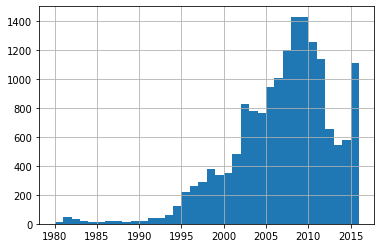

In [18]:
pd.Series(df.query('year_of_release != 7777')['year_of_release']).hist(bins=36)

С начала 90-х наблюдается рост. Пик пришелся на 2005-2012 годы, затем небольшой спад и в 2016 снова существенный рост.
Так же взглянем на изменения количества копий по годам.



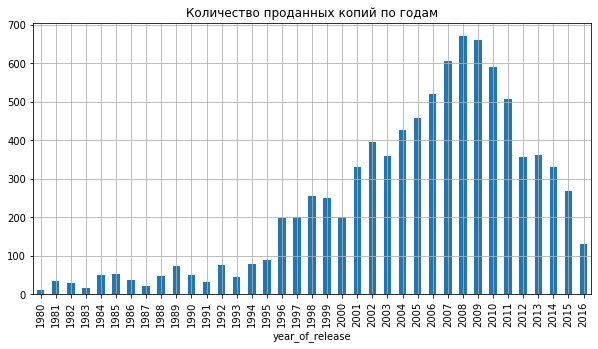

In [19]:
(df.query('year_of_release != 7777')
 .groupby('year_of_release')['sum_sales'].agg('sum')
 .plot(kind='bar', figsize=(10, 5), title='Количество проданных копий по годам', grid=True))
plt.show()

По количеству проданных копий картина похожая, но здесь спад с пиков 2008-2009 гг продолжается, и 2016 год наименее удачный за последние 20 лет, хотя по количеству игр был рост. Возможно, часть игр выходили в конце года, и результат будет заметен уже в 2017-м. Также нужно учитывать, что за 2016 год на текущий момент могут быть не полные данные, что в большей степени касается как раз продаж: релиз игры уже состоялся, а данных о продажах или еще нет, или большая часть продаж игры будет уже в 2017-м.

### Распределение игр по платформам.

Посчитаем, у каких из платформ наибольший объем продаж.

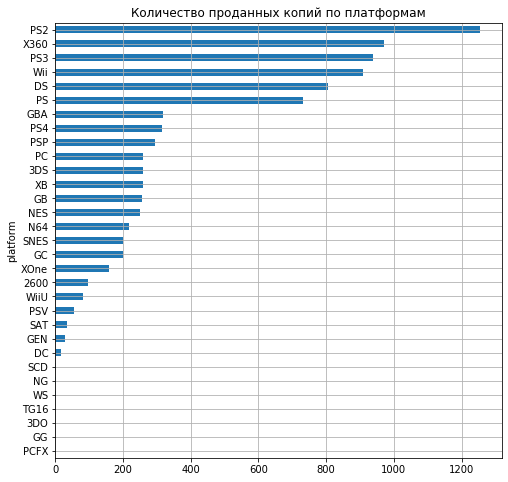

In [20]:
(df.groupby('platform')['sum_sales'].agg('sum').sort_values()
 .plot(kind='barh', figsize=(8, 8), title='Количество проданных копий по платформам', grid=True))
plt.show()

Можно выделить 6 лидеров. На первом месте с заметным отрывом **PS2**, также в шестерке **X360, PS3, Wii, DS и PS**.

Посмотрим количество игр, выходивших на лидирующих платформах, по годам. Начнем смотреть с 1994 года, т.к. ранее было совсем мало релизов.

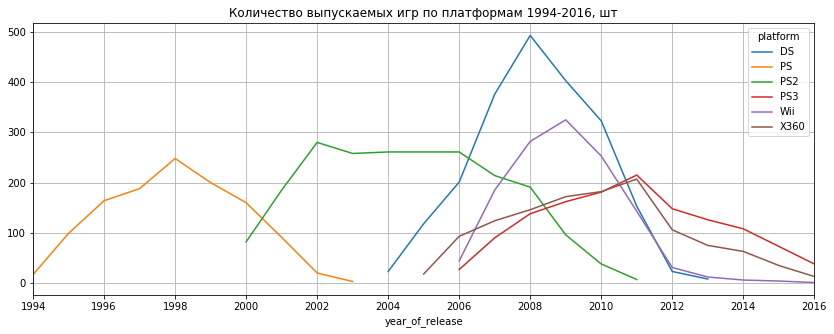

In [21]:
(
    df.query('year_of_release != 7777 & year_of_release >1993 & platform == ["PS2", "X360", "PS3", "Wii", "DS", "PS"]')
    .pivot_table(index='year_of_release', columns='platform', values='name', aggfunc='count')
    .plot(grid=True, figsize=(14, 5), title = 'Количество выпускаемых игр по платформам 1994-2016, шт', x_compat=True)
) 
plt.xticks(np.arange(1994,2017,2))
plt.show()

Посмотрим на показатели выручки в таком же разрезе

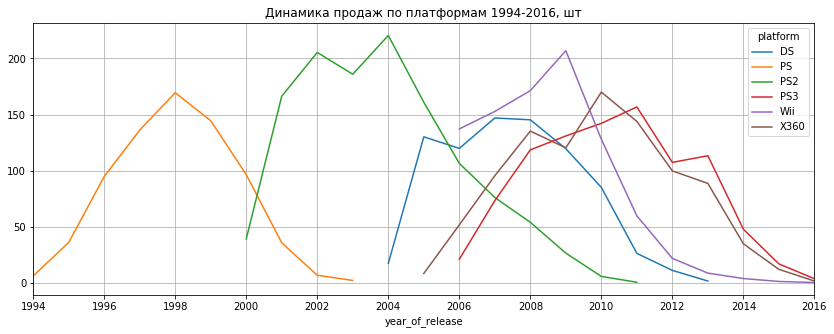

In [22]:
(
    df.query('year_of_release != 7777 & year_of_release >1993 & platform == ["PS2", "X360", "PS3", "Wii", "DS", "PS"]')
    .pivot_table(index='year_of_release', columns='platform', values='sum_sales', aggfunc='sum')
    .plot(grid=True, figsize=(14, 5), title = 'Динамика продаж по платформам 1994-2016, шт', x_compat=True)
) 
plt.xticks(np.arange(1994,2017,2))
plt.show()

На графиках заметно, что у разных платформ схожий жизненный цикл. 

В среднем игровая платформа живет около 10 лет, после чего ей на смену приходят другие. Эта смена хорошо заметна на примере **PS**: в районе 2000-го года идет спад PS, и ей на смену появляется PS2, которая в свою очередь сменяется PS3. 

Выделяется **DS**, которая резко взлетела и на пике в 2008 году существенно превосходила конкурентов по количеству игр. Но её популярность так же быстро закончилась. При этом даже на пике она не превосходила своих основных конкурентов по количеству проданных копий, т.е. игр выпускалось много, но тиражи были не очень большие. 

На графике заметно, что жизненные циклы отобранных наиболее популярных платформ находятся на спаде. За последние три года (2013-2016) выпускались игры только для Wii, X360 и PS3, но и они были на минимальных отметках.

Это говорит о том, что рассматривая лидеров за весь период, мы упустили новые платформы, которые популярны сейчас или находятся на стадии роста, и которые более интересны для оценки перспектив.

Исходя из того, что жизненный цикл платформы не более 10 лет, нас интересуют компании, находящиеся на пике, либо растущие. Взглянем еще раз на распределение продаж, но ограничим период последними шестью годами.



In [23]:
df_lifetime = df.query('year_of_release != 7777').pivot_table(index = 'platform', values = 'year_of_release', aggfunc = ['max', 'min']).reset_index()
df_lifetime = df_lifetime.rename(columns={"year_of_release":"", "max":"max_year", "min":"min_year"}) #уберем двойные названия столбцов и переименуем столбцы
df_lifetime.columns = [t[0] if t[0] else t[1] for t in df_lifetime.columns]
df_lifetime['lifetime'] = df_lifetime['max_year'] - df_lifetime['min_year']
display(df_lifetime)
print('Средняя продолжительность жизни платформы ', df_lifetime.query('max_year < 2016 & lifetime >1')['lifetime'].mean().round(1), 'лет') 


,platform,max_year,min_year,lifetime
0,2600,1989,1980,9
1,3DO,1995,1994,1
2,3DS,2016,2011,5
3,DC,2008,1998,10
4,DS,2013,1985,28
5,GB,2001,1988,13
6,GBA,2007,2000,7
7,GC,2007,2001,6
8,GEN,1994,1990,4
9,GG,1992,1992,0


Средняя продолжительность жизни платформы  8.9 лет


Взглянем на продажи.

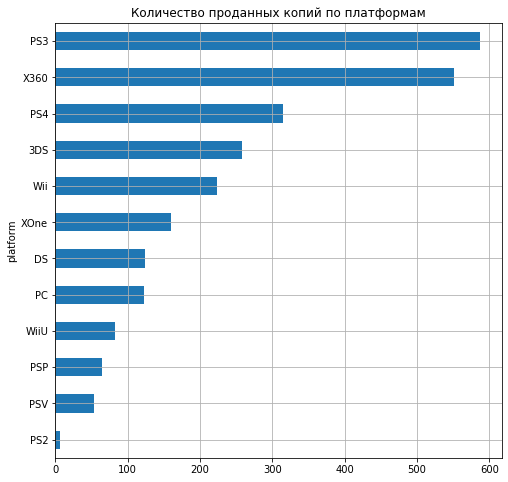

In [24]:

(df.query('year_of_release != 7777 & year_of_release >2009').groupby('platform')['sum_sales'].agg('sum').sort_values()
 .plot(kind='barh', figsize=(8, 8), title='Количество проданных копий по платформам', grid=True))
plt.show()

Данный график статичен, нам более интересна динамика. Построим график с выручкой, скорректированный на данные за последние 6 лет. Выберем лидеров на основании графика выше, но с учетом того, что рассмотренные ранее PS3, Wii и X360 уже в низшей точке - их исключим.

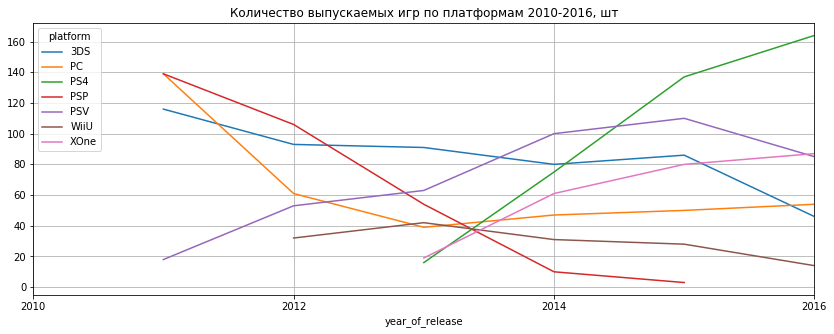

In [25]:
(
    df.query('year_of_release != 7777 & year_of_release >2010 & platform == ["PS4", "XOne", "PC", "WiiU", "3DS", "PSP", "PSV"]')
    .pivot_table(index='year_of_release', columns='platform', values='name', aggfunc='count')
    .plot(grid=True, figsize=(14, 5), title = 'Количество выпускаемых игр по платформам 2010-2016, шт', x_compat=True)
) 
plt.xticks(np.arange(2010,2017,2))
plt.show()

В таком разрезе мы уже видим иные результаты. Явным лидером является PS4, причем похоже, что это только начальная стадия роста. Похожую динамику, но гораздо более медленную показывает XOne. Эти платформы стартовали в одно время, но по итогам 2016 года PS4 примерно в два раза обходит своего конкурента по количеству выпускаемых игр.

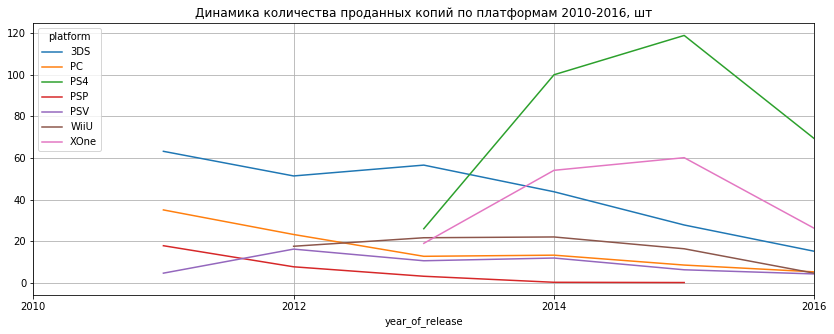

In [26]:
(
    df.query('year_of_release != 7777 & year_of_release >2010 & platform == ["PS4", "XOne", "PC", "WiiU", "3DS", "PSP", "PSV"]')
    .pivot_table(index='year_of_release', columns='platform', values='sum_sales', aggfunc='sum')
    .plot(grid=True, figsize=(14, 5), title = 'Динамика количества проданных копий по платформам 2010-2016, шт', x_compat=True)
) 
plt.xticks(np.arange(2010,2017,2))
plt.show()

Видим подтверждени выводов, сделанных ранее по общей выборке: количество релизов по некоторым платформам растет, а продажи падают. Даже у лидеров роста последних лет PS4 и XOne. Есть какие-то факторы, которые негативно влияют на весь рынок целиком, а не только на отдельных представителей. либо проблема всё же в неполных данных за 2016 год.

Для построения прогнозов на 2017 и последующие периоды стоит использовать данные за последние 3-5 лет, т.к. актуальность довольно быстро теряется.

Создадим новый датафрейм, в котором оставим только данные за 2013-2016 годы, когда на рынке уже были представлены все лидеры, которые у нас есть на конец 2016. 

In [27]:
df_four_years = df.query('year_of_release != 7777 & year_of_release >2012')
df_four_years.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2234 entries, 16 to 16714
Data columns (total 12 columns):
name               2234 non-null object
platform           2234 non-null object
year_of_release    2234 non-null int64
genre              2234 non-null object
na_sales           2234 non-null float64
eu_sales           2234 non-null float64
jp_sales           2234 non-null float64
other_sales        2234 non-null float64
critic_score       2234 non-null float64
user_score         2234 non-null float64
rating             2234 non-null object
sum_sales          2234 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 226.9+ KB


В усеченном датафрейме осталось 2 234 позиции. 
Посмотрим на распределение продаж по платформам с помощью боксплота.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


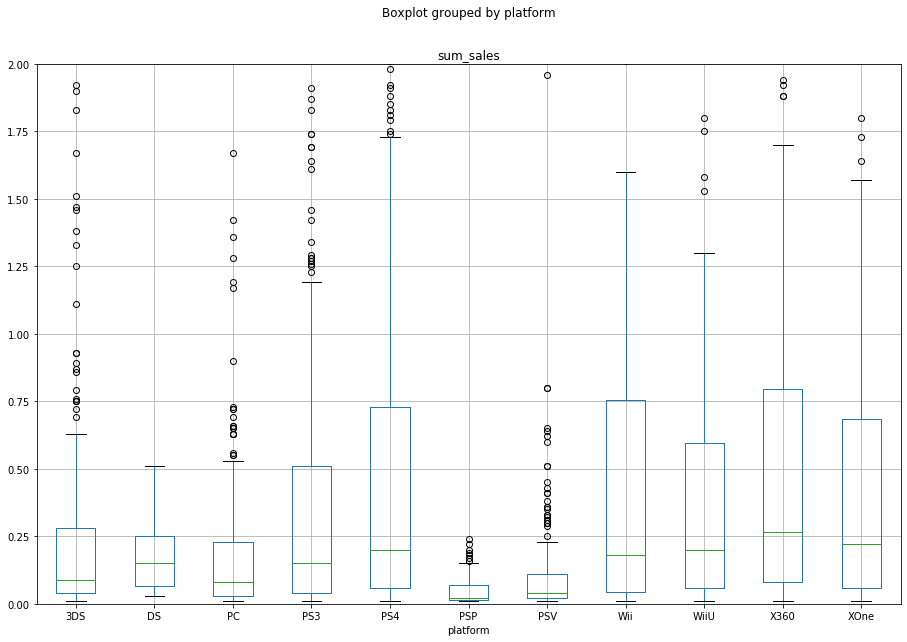

In [28]:

df_four_years.boxplot('sum_sales', by='platform', figsize=(15,10)).set_ylim(0, 2)

import warnings
warnings.filterwarnings('ignore') 

По некоторым платформам (DS, PSP, PSV) разброс не очень большой. 
Если судить по медианному значению, лидерами по продажам являются *X360* и *XOne*. Но если первая платформа, как мы видели ранее, уже идет на спад и её высокий показатель получен за 2013-2014гг, то *XOne* довольно успешно заменила её. Боксплоты этих платформ очень походи: медиана в районе 0,25млн. копий, верхний ус примерно 1,6-1,7млн.копий. Основным конкурентом является *PS4*.

Еще один из лидеров по количеству выпускаемых игр - *PSV* - здесь показывает не очень хорошие результаты: медианное значение меньше 0,05млн.копий, а тиражом более 0,25млн.копий продаются лишь отдельные экземпляры. Это подтверждает предыдущие результаты: по количеству новых игр *PSV* один из лидеров последних лет, а вот по количеству проданных копий наоборот, один из аутсайдеров.

*PC* и *3DS* имеют схожие распределелния. Медианное значение ниже лидеров, и разброс не столь велик. Тиражом более 0,6млн.копий продаются не так много игр, при том что для лидеров это даже меньше границы верхнего квартиля.

### Зависимость продаж и оценок пользователей и критиков.

Оценим зависимость продаж от оценок пользователей и критиков. Для анализа возьмем одну из наиболее популярных платформ последних лет - *PS4*.

Построим диаграмму рассеяния и посмотрим на возможные зависимости. Вначале рассмотрим количество проданных копий в привязке к оценке критиков.

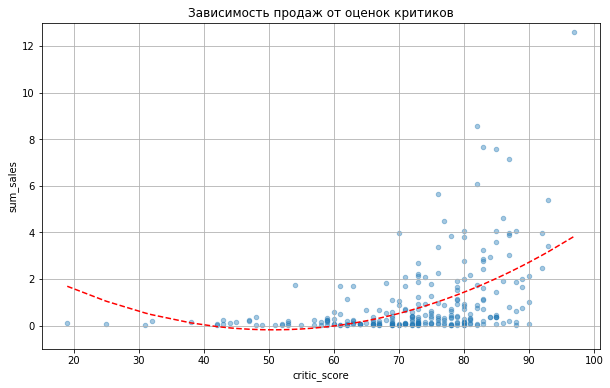

Коэффициент корреляции между продажами и оценками критиков 0.41


In [29]:
df_ps4_sorted_cr = df.query('platform == "PS4" & critic_score != 777 ').sort_values('critic_score')

df_ps4_sorted_cr.plot(x='critic_score', y='sum_sales', kind='scatter', title='Зависимость продаж от оценок критиков', 
                    ylim=(-1, 13), grid=True, figsize=(10, 6), alpha = 0.4)

z = np.polyfit(df_ps4_sorted_cr['critic_score'], df_ps4_sorted_cr['sum_sales'], 2)
p = np.poly1d(z)
plt.plot(df_ps4_sorted_cr['critic_score'], p(df_ps4_sorted_cr['critic_score']),"r--")
plt.show()
print('Коэффициент корреляции между продажами и оценками критиков', df_ps4_sorted_cr['critic_score'].corr(df_ps4_sorted_cr['sum_sales']).round(2)) #посчитаем корреляцию между отзывами и продажами

Определенная зависимость просматривается: среди игр, проданных большим тиражом, большинство имеют высокую оценку критиков. Но при этом и среди высоко оцененных игр очень много позиций с низкими продажами. И коэффициент корреляции равен 0,4 - т.е. прямой зависимость есть, но не очень сильная.

Теперь построим аналогичную диаграмму, но уже в контексте оценок пользователей. 

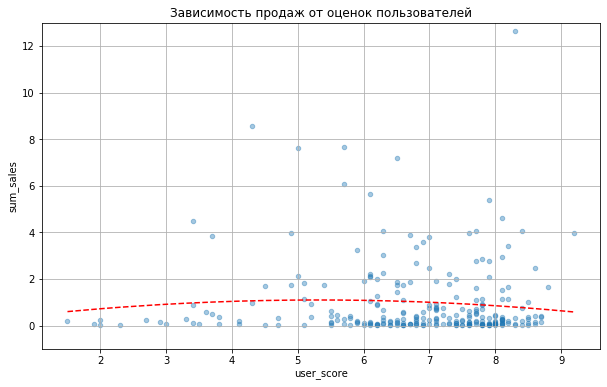

Коэффициент корреляции между продажами и оценками пользователей -0.07


In [30]:
df_ps4_sorted_user = df.query('platform == "PS4" & user_score != 77').sort_values('user_score')

df_ps4_sorted_user.plot(x='user_score', y='sum_sales', kind='scatter', title='Зависимость продаж от оценок пользователей', 
                    ylim=(-1, 13), grid=True, figsize=(10, 6), alpha = 0.4)

z = np.polyfit(df_ps4_sorted_user['user_score'], df_ps4_sorted_user['sum_sales'], 2)
p = np.poly1d(z)
plt.plot(df_ps4_sorted_user['user_score'], p(df_ps4_sorted_user['user_score']),"r--")
plt.show()
print('Коэффициент корреляции между продажами и оценками пользователей', df_ps4_sorted_cr['user_score'].corr(df_ps4_sorted_cr['sum_sales']).round(2)) 

Здесь зависимость совсем не просматроивается.Большинство игр продаются низким тиражом не зависимо от оценки. При этом среди игр, проданных большим количеством копий,  есть как с высокими оценками, так и с очень низкими. Например, на 2-4 местах по количеству продаж находятся игры с оценкой пользователей от 4 до 6 по 10 бальной шкале.  

Если о зависимости оценок критиков на продажи мы можем говорить, то связи между оценкой пользователей и продажами нет. Это можно объяснить, т.к. оценки критиков чаще всего появляются раньше, в районе даты выхода игры или в короткий срок после, и многие покупают основываясь на них. А затем пользователи пробуют, получают собственное впечатление, и выставляют свои оценки. Также нельзя исключать такого фактора, что критики могут быть заинтересованы в выставлении определенных оценок, или намеренном завышении рейтинга определенных игр. 

Построим такие же диаграммы, но уже для всех платформ за актуальный период - 2013-2016 гг.

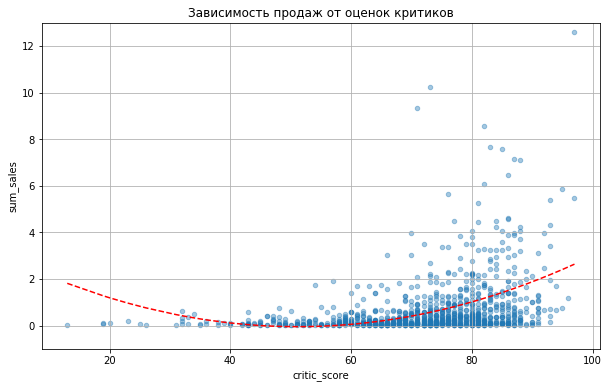

Коэффициент корреляции между продажами и оценками критиков 0.31


In [31]:
df_sorted_cr = df_four_years.query('critic_score != 777 ').sort_values('critic_score')

df_sorted_cr.plot(x='critic_score', y='sum_sales', kind='scatter', title='Зависимость продаж от оценок критиков', 
                    ylim=(-1, 13), grid=True, figsize=(10, 6), alpha = 0.4)

z = np.polyfit(df_sorted_cr['critic_score'], df_sorted_cr['sum_sales'], 2)
p = np.poly1d(z)
plt.plot(df_sorted_cr['critic_score'], p(df_sorted_cr['critic_score']),"r--")
plt.show()
print('Коэффициент корреляции между продажами и оценками критиков', df_sorted_cr['critic_score'].corr(df_sorted_cr['sum_sales']).round(2)) #посчитаем корреляцию между отзывами и продажами

Зависимость просматривается еще слабее. Да и коэффициент корреляции  ниже.
Посмотрим отличаются ли зависимость от оценок пользователей. 

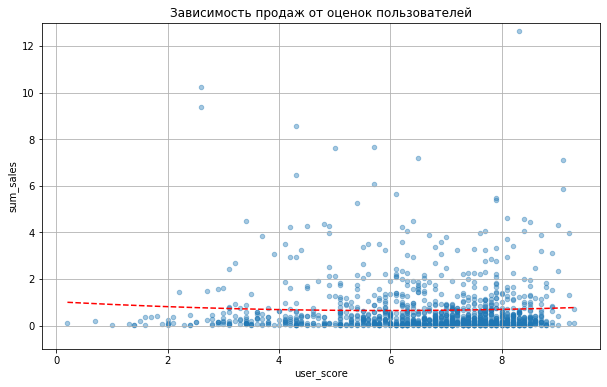

Коэффициент корреляции между продажами и оценками пользователей -0.0


In [32]:
df_sorted_user = df_four_years.query('user_score != 77').sort_values('user_score')

df_sorted_user.plot(x='user_score', y='sum_sales', kind='scatter', title='Зависимость продаж от оценок пользователей', 
                    ylim=(-1, 13), grid=True, figsize=(10, 6), alpha = 0.4)

z = np.polyfit(df_sorted_user['user_score'], df_sorted_user['sum_sales'], 2)
p = np.poly1d(z)
plt.plot(df_sorted_user['user_score'], p(df_sorted_user['user_score']),"r--")
plt.show()
print('Коэффициент корреляции между продажами и оценками пользователей', df_sorted_user['user_score'].corr(df_sorted_user['sum_sales']).round(2)) 

И здесь похожая картина - зависимости между количеством проданных копий и оценками пользователей нет.

### Анализ по жанрам.

Посмотрим игры каких жанров наиболее часто выходили в последние годы.

In [33]:
print(df_four_years['genre'].value_counts()) 

Action          767
Role-Playing    292
Adventure       245
Sports          214
Shooter         187
Misc            155
Racing           85
Fighting         80
Platform         74
Simulation       62
Strategy         56
Puzzle           17
Name: genre, dtype: int64


С большим отрывом лидирует `action`. 

Оценим среднее количество продаж по жанрам. Используем для этого медиану, чтобы исключить влияние выбросов. 

In [34]:
print(df_four_years.groupby('genre')['sum_sales'].median().sort_values(ascending=False))

genre
Shooter         0.450
Sports          0.240
Platform        0.225
Role-Playing    0.125
Fighting        0.125
Racing          0.120
Action          0.110
Simulation      0.100
Misc            0.100
Strategy        0.080
Puzzle          0.060
Adventure       0.030
Name: sum_sales, dtype: float64


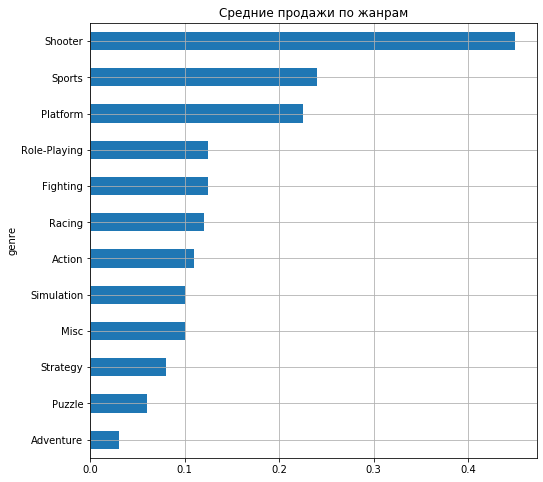

In [35]:
(df_four_years.groupby('genre')['sum_sales'].median().sort_values()
 .plot(kind='barh', figsize=(8, 8), title='Средние продажи по жанрам', grid=True))
plt.show()

И хотя `action` впереди по количеству релизов, по среднему числу проданных копий этот жанр лишь в середине рейтинга в последние годы. Лучше всего продаются игры из жанра `Shooter`, они обходят ближайших конкурентов  `Sports` и `Platform` примерно в 2 раза.

`Strategy` и `Puzzle` находятся внизу рейтинга как по количеству выпущенных игр, так и по средним продажам. Вероятно, из-за низкой популярности эти игры не пользуются спросом у разработчиков.

### Анализ по регионам.

Проанализируем характерные признаки для пользователей в разных регионах.

Сгруппируем данные по платформам.

In [36]:
df_sales_grouped = df_four_years.groupby('platform')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum() 
display(df_sales_grouped)

,na_sales,eu_sales,jp_sales,other_sales
platform,,,,
3DS,38.20,30.96,67.81,6.28
DS,0.57,0.85,0.00,0.12
PC,11.17,25.61,0.00,3.00
PS3,63.50,67.81,23.35,26.77
PS4,108.74,141.09,15.96,48.35
PSP,0.00,0.17,3.29,0.04
PSV,5.04,6.10,18.59,3.26
Wii,6.56,5.93,0.05,1.12
WiiU,29.21,19.85,10.88,4.69


Построим гистограммы количества проданных копий по платформам по основным регионам.

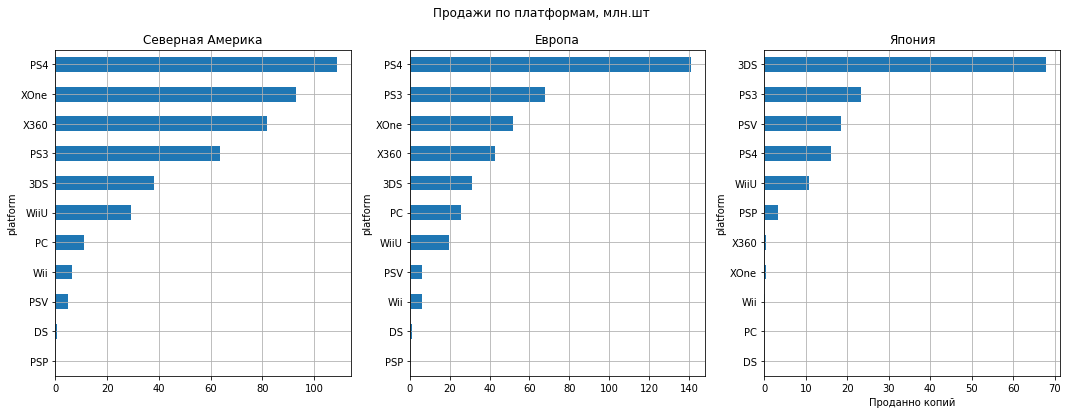

In [37]:

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Продажи по платформам, млн.шт')
df_sales_grouped["na_sales"].sort_values().plot(ax=axes[0], kind='barh', title='Северная Америка', grid=True)
plt.xlabel("Проданно копий")
df_sales_grouped["eu_sales"].sort_values().plot(ax=axes[1], kind='barh', title='Европа', grid=True);
df_sales_grouped["jp_sales"].sort_values().plot(ax=axes[2], kind='barh', title='Япония', grid=True)


Лидер по продажам в Европе и Северной Америке (СА) один и тот же - *PS4*. Но если в Европе эта платформа обгоняет ближайшего конкурента более чем в два раза, то в СА разрывы не столь велики. Пятерка лидеров в этих регионах одинаковая, отличается только порядок распределения мест. В Японии же другой лидер, и также с отрывом - *3DS*, который занимает лишь пятое место в других двух рассматриваемых регионах. При этом *PS4* здесь лишь на четвертом месте.

Вероятно, в СА и Европе охотнее пробуют новые платформы. А у Японии же существенный потенциал для роста новых платформ *PS4* и *XOne*.

Посмотрим на эти же данные не в абсолютных значениях, а в долях. Рассчитаем доли продаж по платформам в каждом из регионов.

In [38]:
df_sales_grouped['na_shares'] = (df_sales_grouped['na_sales']/df_sales_grouped['na_sales'].sum()).round(2)
df_sales_grouped['eu_shares'] = (df_sales_grouped['eu_sales']/df_sales_grouped['eu_sales'].sum()).round(2)
df_sales_grouped['jp_shares'] = (df_sales_grouped['jp_sales']/df_sales_grouped['jp_sales'].sum()).round(2)
display(df_sales_grouped)

,na_sales,eu_sales,jp_sales,other_sales,na_shares,eu_shares,jp_shares
platform,,,,,,,
3DS,38.20,30.96,67.81,6.28,0.09,0.08,0.48
DS,0.57,0.85,0.00,0.12,0.00,0.00,0.00
PC,11.17,25.61,0.00,3.00,0.03,0.07,0.00
PS3,63.50,67.81,23.35,26.77,0.15,0.17,0.17
PS4,108.74,141.09,15.96,48.35,0.25,0.36,0.11
PSP,0.00,0.17,3.29,0.04,0.00,0.00,0.02
PSV,5.04,6.10,18.59,3.26,0.01,0.02,0.13
Wii,6.56,5.93,0.05,1.12,0.01,0.02,0.00
WiiU,29.21,19.85,10.88,4.69,0.07,0.05,0.08


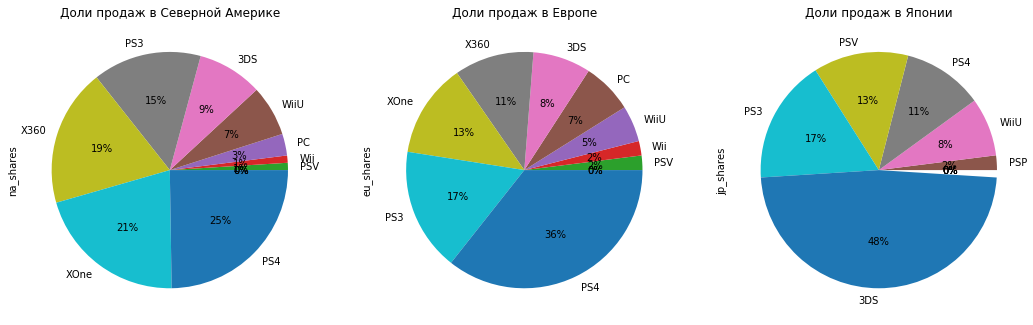

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
df_sales_grouped["na_shares"].sort_values().plot(ax=axes[0], kind='pie', autopct='%1.0f%%', title='Доли продаж в Северной Америке', grid=True)
df_sales_grouped["eu_shares"].sort_values().plot(ax=axes[1], kind='pie', autopct='%1.0f%%', title='Доли продаж в Европе')
df_sales_grouped["jp_shares"].sort_values().plot(ax=axes[2], kind='pie', autopct='%1.0f%%', title='Доли продаж в Японии')


В каждом из регионов пятерка лидеров занимает подавляющую часть рынка, а тройка занимает минимум две трети. Стоит ориентироваться на эти платформы. При этом нужно учитывать, что Япония медленне воспринимает нововведени и следует с некоторым опозданием. 

### Анализ по жанрам.

Взглянем какие жанры популярны в разных регионах. Для этого также воспользуемся `groupby`.

In [40]:
df_sales_grouped_genre = df_four_years.groupby('genre')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum() 
display(df_sales_grouped_genre)

,na_sales,eu_sales,jp_sales,other_sales
genre,,,,
Action,126.11,118.38,40.49,37.24
Adventure,7.14,8.25,5.82,2.43
Fighting,15.55,8.55,7.65,3.56
Misc,27.49,20.04,9.20,6.09
Platform,18.14,15.58,4.79,4.12
Puzzle,0.83,1.00,1.18,0.16
Racing,12.96,20.19,2.30,4.44
Role-Playing,46.40,36.97,51.04,11.48
Shooter,109.74,87.86,6.61,28.77


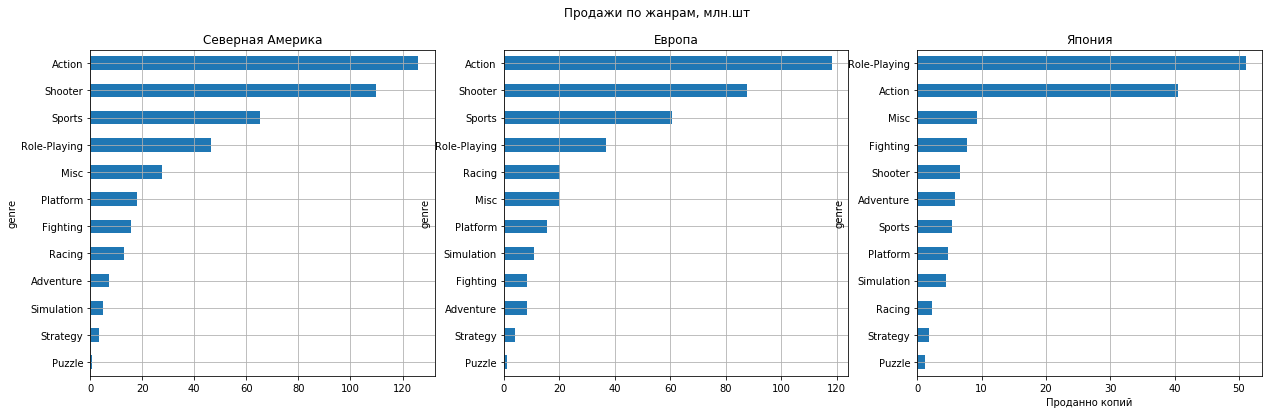

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
fig.suptitle('Продажи по жанрам, млн.шт')
df_sales_grouped_genre["na_sales"].sort_values().plot(ax=axes[0], kind='barh', title='Северная Америка', grid=True)
plt.xlabel("Проданно копий")
df_sales_grouped_genre["eu_sales"].sort_values().plot(ax=axes[1], kind='barh', title='Европа', grid=True);
df_sales_grouped_genre["jp_sales"].sort_values().plot(ax=axes[2], kind='barh', title='Япония', grid=True)

И здесь видим схожесть вкусов пользователей Северной Америки и Европы, и заметное отличие пользователей в Японии.

Первая четверка в Европе и СА абсолютно одинаковая, и даже распределение по количеству продаж похожи. В Японии же два лидера: `Role-Playing	` и `Action`, которые в разы превосходят остальных. При чем продажи `Role-Playing` в абсолютном выражении превосходят Европу и СА, хотя общий объем рынка в Японии меньше.

### Влияние рейтинга на продажи.

Изучим оказывает ли влияние рейтинг на продажи в разных регионах.

Краткое описание рейтинга:
- **E** («Everyone») — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет.
- **E10+** («Everyone 10 and older») — «Для всех от 10 лет и старше»
- **T** («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет. 
- **M** («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет.

У части игр рейтинг не определен или был пропущен, мы заменили его маркером **no_rating**. Оставим эти данные для понимания общей картины.


In [42]:
df_sales_grouped_rating = df_four_years.groupby('rating')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum() 
display(df_sales_grouped_rating)

,na_sales,eu_sales,jp_sales,other_sales
rating,,,,
E,79.05,83.36,15.14,22.61
E10+,54.24,42.69,5.89,12.57
M,165.27,145.57,14.11,47.08
T,49.79,41.95,20.59,14.29
no_rating,89.42,78.91,85.05,23.46


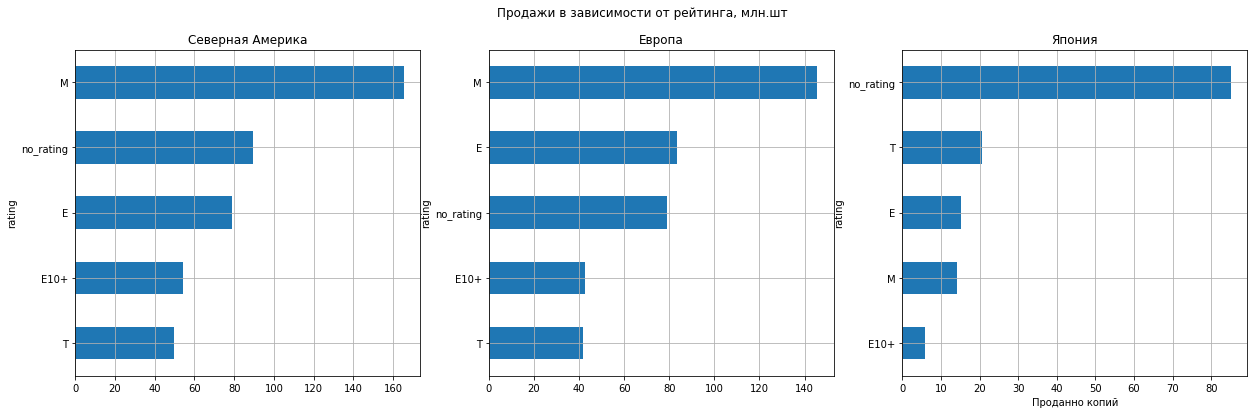

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
fig.suptitle('Продажи в зависимости от рейтинга, млн.шт')
df_sales_grouped_rating["na_sales"].sort_values().plot(ax=axes[0], kind='barh', title='Северная Америка', grid=True)
plt.xlabel("Проданно копий")
df_sales_grouped_rating["eu_sales"].sort_values().plot(ax=axes[1], kind='barh', title='Европа', grid=True);
df_sales_grouped_rating["jp_sales"].sort_values().plot(ax=axes[2], kind='barh', title='Япония', grid=True)

И снова очень похожие картины в СА и Европе: лидируют игры "17+", довольно большую долю составляют игры, в которых рейтинг не определен или отсутствует.
В Японии же подобные игры составляют абсолютное большинство - суммарно превосходят остальные 4 категории. 

На основании предыдущего анализа уже можно сделать вывод, что интересы пользователей в Японии отличаются от СА и Европы. Вероятно, в Японии популярны некоторые игры, которые малопопулярны или не популярны совсем в СА и Европе, и ассоциация, определяющая возрастной рейтинг компьютерных игр, просто не присваивала им рейтинг в связи с низкой популярностью.

## Выдвижение и проверка гипотез

Выдвинем две гипотезы и проверим их на предоставленных данных. Для анализа используем актуальные данные за последние 4 года.

### Гипотеза №1 Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. 

Сравним пользовательские рейтинги платформ Xbox One и PC. Сформулируем нулевую и альтернативную гипотезы. В нулевой гипотезе должен присутствовать знак равенства: 

**Нулевая гипотеза $Н_{0}$** - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

**Альтернативная гипотеза $Н_{1}$** - Средние пользовательские рейтинги платформ Xbox One и PC различается. Альтернативная гипотеза двухсторонняя - нам не важно в какую сторону будет отклонение, важен сам факт наличия отклонения, т.е. то, что пользовательские рейтинги не равны.

Принимать или отвергать нулевую гипотезу будем по **p-value** - это вероятность получить наблюдаемый или ещё более далёкий от предполагаемого результат при условии, что нулевая гипотеза верна.

Установим уровень значимости — суммарную вероятность того, что измеренное эмпирически значение окажется далеко от среднего - равным 0,05.

Т.к. проверяем гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применим метод scipy.stats.ttest_ind 

In [44]:
alpha = 0.05 

results = st.ttest_ind(df_four_years.query('platform == "XOne" & user_score != 77')['user_score'], df_four_years.query('platform == "PC" & user_score != 77')['user_score']) 

print('p-значение: ', results.pvalue.round(6))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.163904
Не получилось отвергнуть нулевую гипотезу


Мы не можем подтвердить данную гипотезу, но результаты также не дают нам оснований отвергнуть её.

### Гипотеза №2 Средние пользовательские рейтинги жанров Action и Sports разные.

Сравним пользовательские рейтинги по двум популярным жанрам: Action и Sports. 

**Нулевая гипотеза $Н_{0}$** - Средние пользовательские рейтинги жанров Action и Sports одинаковые.

**Альтернативная гипотеза $Н_{1}$** - Средние пользовательские рейтинги жанров Action и Sports различаются. Альтернативная гипотеза снова двухсторонняя.


Установим уровень значимости alpha таким же 0,05.


In [45]:
alpha = 0.05 

results = st.ttest_ind(df_four_years.query('genre == "Action" & user_score != 77')['user_score'], df_four_years.query('genre == "Sports" & user_score != 77')['user_score']) 

print('p-значение: ', results.pvalue.round(6))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.0
Отвергаем нулевую гипотезу


Вероятность такого события равна нулю или мала настолько, что близка к нулю. Мы можем отвергнуть нулевую гипотезу - средние пользовательские рейтинги жанров Action и Sports различаются.

## Общий вывод.

Провели исследование рынка компьютерных игр на основании данных о релизах и продажах за 1980-2016 годы.

Пик релизов пришёлся на 2005-2012 годы, затем наметился небольшой спад.

Жизненный цикл платформы в среднем составляет около 10 лет, при этом после 5-6 года начинается существенный спад. На текущий момент актуальны следующие платформы: *PS4*, *XOne*, *PC*, *3DS*, *PSV*. При выпуске новых игр следует ориентироваться на них, особенно на первые две платформы.

Рейтинг пользователей никак не влияет на продажи, среди лидеров по количеству реализованных копий есть как игры с высокой оценкой, так и с оценками ниже среднего. При этом можно говорить о некоторой зависимости между величиной продаж и оценкой критиков: большинство высокотиражных игр имеют высокую оценку критиков. При начале продаж новых игр стоит обратить внимание на работу с критиками: предоставить им пробные версии, дать описание игр с указанием особенностей и т.д.

Среди жанров абсолютным фаворитом является `Action`, также популярны `Role-Playing` и `Adventure`. При этом игр этих жанров нет в топе по продажам, они занимают лишь 7, 4 и 12 (места) места соответственно.

По продажам же лидируют `Shooter`,`Sports` и `Platform`. которые находятся в середине рейтинга по количеству релизов. Здесь можно говорить о расхождении оценки популярности со стороны разработчиков и пользователей: разработчики выпускают не те жанры, которые актуальны и интересны пользователям. 

Игр в жанрах `Action`, `Role-Playing` и `Adventure` выпускается довольно много, конкуренция высока. При это они не пользуются большой популярностью. Стоит обратить внимание на жанры, которые хорошо продаются, но где не столь много релизов. При этом также могут действовать и другие участники рынка, поэтому данную информацию стоит периодически актуализировать.

При анализе по регионам можно говорить, что Северная Америка и Европа очень похожи, а Япония существенно отличается:
- в Японии медленнее внедряются новые платформы, это происходит с некоторой задержкой;
- в Японии очень популярна платформа *3DS*, которая не пользуется спросом в других регионах;
- по жанрам различия тоже заметны, но не столь сильно выражены: в СА и Европе абсолютно одинаковая первая пятерка лидеров, в Японии же в лидерах присутствуют схожие жанры, но их порядок и разрывы между ними отличаются. 
- в СА и Европе лидируют игры с возрастным рейтингом M («Mature»), в Японии же большинство игр без указания рейтинга - возможно это какие-то специфические местные продукты.


Некоторое искажение в данные вносит то, что за 2016 год пока имеется не полная информация.


Рассмотрели гипотезы о равенстве средних пользовательских рейтингов платформ Xbox One и PC, а также о равенстве средних пользовательских рейтингов жанров Action и Sports. Первую гипотезу не удалось отвергнуть, вероятность же второй близка к нулю.
